In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report
from xgboost import XGBClassifier
import optuna

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
load_dotenv(override=True)

True

In [3]:
DIR_DATA_PROCESSED: str = Path(os.getenv("DIR_DATA_PROCESSED"))

In [4]:
df = pd.read_csv(f"{DIR_DATA_PROCESSED}/data.csv")

In [5]:
X = df.drop(columns="isFraud")
y = df["isFraud"]

In [6]:
print(f"skew = {y[y==1].shape[0]/y.shape[0]}")

skew = 0.002964544224336551


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Logistic Regression

In [11]:
numeric_preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), [c for c in X.columns if c != "type"]),
    ]
)

In [16]:
pipeline = Pipeline([
    ("preprocessor", numeric_preprocessor),
    ("smote", SMOTE(.05)),
    ("lr", LogisticRegression(solver="lbfgs", max_iter=1000))
])

/home/paul/PycharmProjects/personal/qonto-skill-test/.venv/lib/python3.8/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=0.05 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


In [17]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['step', 'amount',
                                                   'oldBalanceOrig',
                                                   'newBalanceOrig',
                                                   'oldBalanceDest',
                                                   'newBalanceDest',
                                                   'errorBalanceOrig',
                                                   'errorBalanceDest',
                                                   'hourOfDay',
                                                   'dayOfWeek'])])),
                ('smote', SMOTE(sampling_strategy=0.05)),
                ('lr', LogisticRegression(max_iter=1000))])

In [18]:
y_pred = pipeline.predict_proba(X_test)
labels_pred = y_pred[:, 1] > 0.5

In [19]:
print('AUPRC = {}'.format(average_precision_score(y_test, y_pred[:, 1])))

AUPRC = 0.6535354211290821


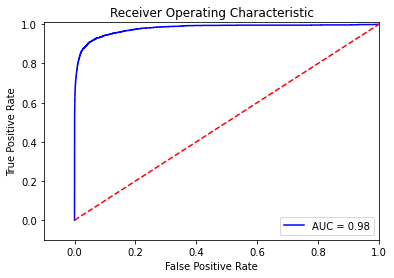

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [27]:
print(confusion_matrix(y_test, labels_pred))

[[550988   1451]
 [   520   1123]]


In [26]:
print(classification_report(y_test, labels_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.44      0.68      0.53      1643

    accuracy                           1.00    554082
   macro avg       0.72      0.84      0.77    554082
weighted avg       1.00      1.00      1.00    554082



# XGBoost

In [28]:
weights = (y == 0).sum() / ((y == 1).sum())

In [33]:
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4)
clf.fit(X_train, y_train)

In [39]:
y_pred = clf.predict_proba(X_test)
labels_pred = y_pred[:, 1] > 0.5

In [40]:
print(f"AUPRC = {average_precision_score(y_test, y_pred[:, 1])}")

AUPRC = 0.9965729926359266


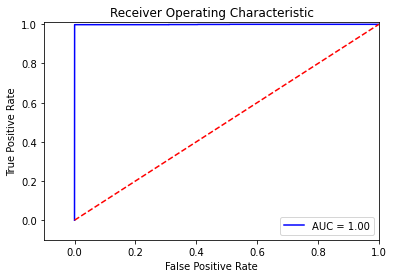

In [41]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [44]:
print(confusion_matrix(y_test, labels_pred))

[[552416     23]
 [     5   1638]]


In [45]:
print(classification_report(y_test, labels_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.99      1.00      0.99      1643

    accuracy                           1.00    554082
   macro avg       0.99      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



# Hyper Optimization

In [49]:
def objective(trial, X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,random_state=42)
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    clf = XGBClassifier(**param)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    return average_precision_score(y_train, y_pred[:, 1])

In [50]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)

[I 2022-07-10 09:31:13,527] A new study created in memory with name: no-name-5b783f64-2e6f-4f3c-8c88-9082e5f7ea2f


KeyboardInterrupt: 